In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import tqdm

In [97]:
plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)
plt.gcf().subplots_adjust(bottom=0.15, wspace=0.0, hspace=0.0, top=0.96, right=0.97, left=0.12)

Let's create a planet. It has a period of 10 days, no eccentricity, a phase so that it transits at 9.5 days, and an RV semiamplitude of exactly 1 m/s.

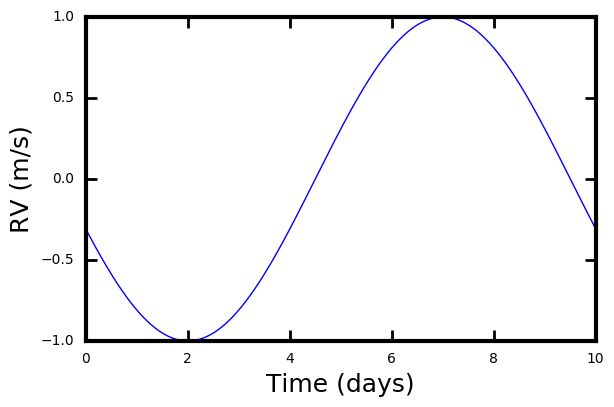

In [50]:
p = 10.0
e = 0.0
z = 4.5

t = np.arange(0, 10, 0.001)

v = np.sin(2*np.pi*(t-z)/p)

plt.plot(t,v)
plt.ylabel('RV (m/s)', fontsize=18)
plt.xlabel('Time (days)', fontsize=18)
plt.show()

We'll assign a seed to our random number generator, so that you can reproduce my results exactly.

In [99]:
np.random.seed(20161102)

We'll need to fit our signals. Our fitting will, for simplicity, assume circular orbits. (Most---but not all---short period planets are on nearly circular orbits.) Since we know the planet transits, we know its period and phase, leaving the Doppler amplitude and RV zeropoint to be fit for.

In [100]:
def fit_signal(t_obs, v_obs, e_obs):
    fitfunc = lambda theta, x: theta[0]*np.sin(2*np.pi*(x-z)/p) + theta[1] # Target function
    errfunc = lambda theta, x, y, e: (fitfunc(theta, x) - y)/e # Distance to the target function
    p0 = [1., 0.] # Initial guess for the parameters

    p1 = optimize.leastsq(errfunc, p0, args=(t_obs, v_obs, e_obs), full_output=True)
    popt = p1[0]
    pcov = p1[1]

    s_sq = (errfunc(popt, t_obs, v_obs, e_obs)**2).sum()/(len(v_obs)-len(p0))
    pcov = pcov * s_sq

    sigma = np.sqrt(np.diag(pcov))[0]

    signal = popt[0]
    #print(signal/sigma, signal)
    
    return signal/sigma, signal

    

Let's create lots of versions of this planet and fit it. At each iteration, we will take 3 observations and then start measuring the fit to the data. We'll then continue taking observations and seeing how the inferred mass and uncertainty changes until we have at least 8 observations and the mass is measured to be nonzero at 6 sigma (so that the fractional uncertainty on the mass is 17%, assuming a Gaussian posterior. Once that's satisfied, we'll record the mass that we infer, the uncertainty on that mass, and the number of observations it took us to get there.

In [101]:
niter = 20000
out_mass = np.zeros(niter)
out_sigma = np.zeros_like(out_mass)
out_i = np.zeros_like(out_mass)
for j in tqdm.tqdm(range(len(out_mass))): 
    noise = 1.0
    t_obs = np.array([])
    v_obs = np.array([])
    e_obs = np.array([])

    for i in range(3):
        t_obs = np.append(t_obs, np.random.random()*10)
        v_obs = np.append(v_obs, np.sin(2*np.pi*(t_obs[i]-z)/p) + np.random.normal(0, noise))
        e_obs = np.append(e_obs, noise)

    signif, signal = fit_signal(t_obs, v_obs, e_obs)

    while ((signif < 6) or (len(t_obs) < 8)) :
        i += 1
        t_obs = np.append(t_obs, np.random.random()*10)
        v_obs = np.append(v_obs, np.sin(2*np.pi*(t_obs[-1]-z)/p) + np.random.normal(0, noise))
        e_obs = np.append(e_obs, noise)
        signif, signal = fit_signal(t_obs, v_obs, e_obs)
    #print(signif, signal)
        
    out_mass[j] = signal
    out_sigma[j] = signal/signif
    out_i[j] = i


100%|██████████| 20000/20000 [06:56<00:00, 48.03it/s]


Let's plot what that distribution of learned masses/Doppler amplitudes looks like. Remember, the input signal is exactly 1 m/s for every planet.

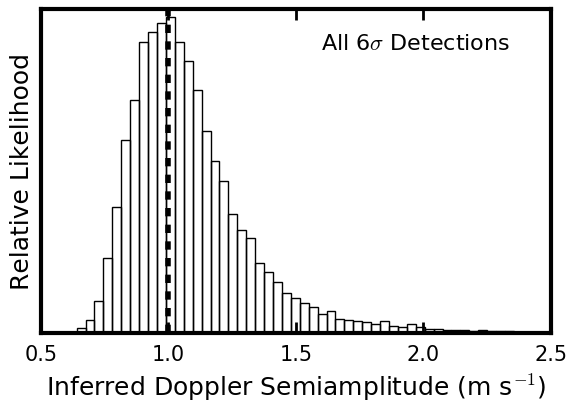

In [102]:
plt.hist(out_mass, np.arange(0.5, 2.5, 0.035), facecolor='none')
plt.xlabel('Inferred Doppler Semiamplitude (m s$^{-1}$)', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Relative Likelihood', fontsize=18)
plt.yticks([],[])
plt.axvline(1.0, linestyle='--', color='k', linewidth=4)
plt.text(1.6, 1400, 'All 6$\sigma$ Detections', fontsize=16)
plt.savefig('f1.png')
plt.show()

That doesn't look like what we put in! Let's look at each individual mass measurement

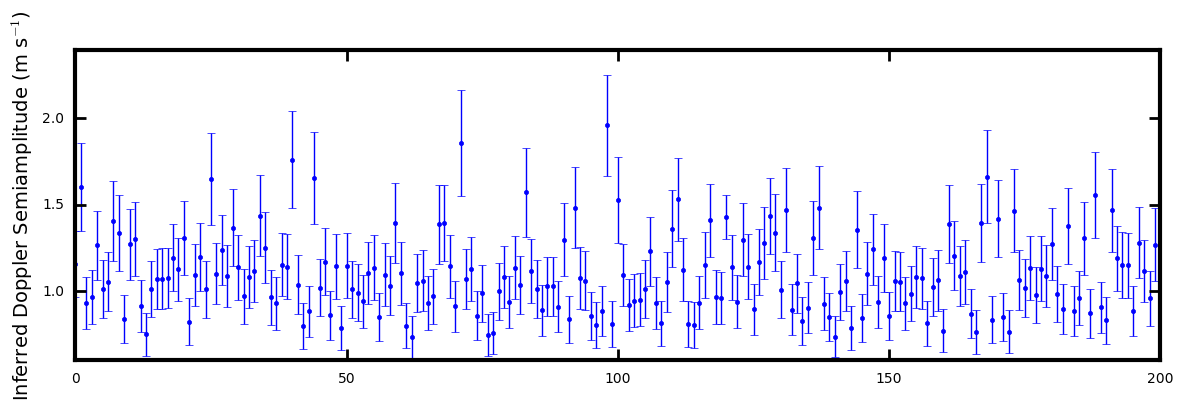

In [103]:
plt.figure(figsize=(14,4))
plt.errorbar(np.arange(200), out_mass[0:200], yerr=out_sigma[0:200], fmt='.')
plt.ylabel('Inferred Doppler Semiamplitude (m s$^{-1}$)', fontsize=14)
plt.show()

In [104]:
print(np.mean(out_mass), np.median(out_mass))

1.0910932710015275 1.0400664048096893


Well that's a bit skewed, but what does the distribution look like?

In [105]:
print(len(out_mass[out_mass > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 1*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 2*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 3*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 1.0 > 1.00])/len(out_mass))

0.58845
0.24375
0.06965
0.0176
0.01035


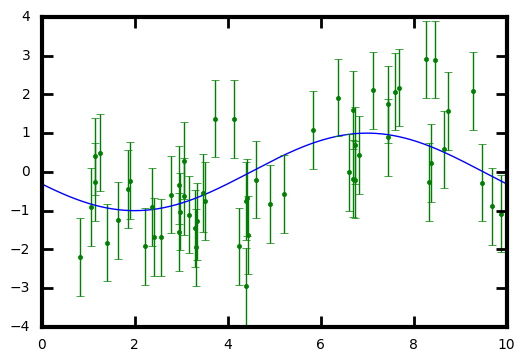

1.1508305250780295 0.19038520303458903


In [106]:
plt.plot(t,v)
plt.errorbar(t_obs, v_obs, yerr=e_obs, fmt='.')
plt.show()

print(out_mass[-1], out_sigma[-1])

we can possibly live with that, as long as everything gets published. But not all planets are observed to completion in the real world, especially in the middle of a survey when there's clear benefits to publishing one's early detections. What if we only consider the cases where there's a six sigma mass within 60 epochs?

0.40875
1.227095937703443 1.289375485050602
0.9462996941896025
0.5692966360856269
0.17039755351681957
0.04305810397553517
0.025321100917431193


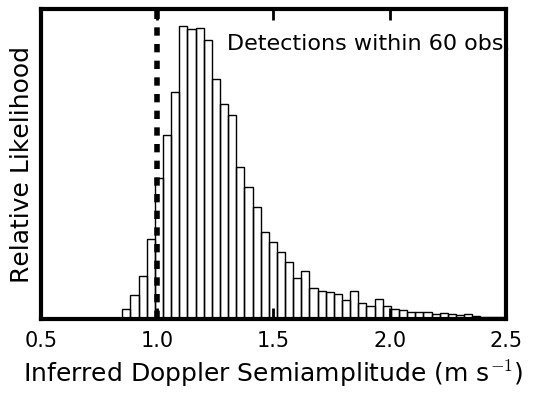

In [113]:
print(len(out_i[out_i < 60])/20000)

out_mass60 = out_mass[out_i < 60]
out_sigma60 = out_sigma[out_i < 60]
print(np.median(out_mass60), np.mean(out_mass60))
print(len(out_mass60[out_mass60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 1*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 2*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 3*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 1.0 > 1.00])/len(out_mass60))

plt.hist(out_mass60, np.arange(0.5, 2.5, 0.035), facecolor='none')
plt.xlabel('Inferred Doppler Semiamplitude (m s$^{-1}$)', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Relative Likelihood', fontsize=18)
plt.yticks([],[])
plt.axvline(1.0, linestyle='--', color='k', linewidth=4)
plt.text(1.3, 610, 'Detections within 60 obs.', fontsize=16)
plt.savefig('f2.png')
plt.show()


Oh goodness! That's way more biased. We probably would prefer not to live with that, especially if we're trying to understand the compositions of a large number of planets statistically. 90% have masses overestimated!

Instead, let's repeat this exercise, but instead of going until we measure a mass that has a 16% uncertainty on the inferred mass \hat{M}, let's go until we measure a mass that has a 16% uncertainty on the true mass M. In practice we don't know that, of course, but we can make a prediction of what we think it is going to be. Even if this prediction is off, the change here is that we're going to observe until we achieve a predetermined absolute uncertainty on the inferred mass, not a predetermined relative uncertainty.

In [82]:
niter = 20000
out_mass = np.zeros(niter)
out_sigma = np.zeros_like(out_mass)
out_i = np.zeros_like(out_mass)
for j in tqdm.tqdm(range(len(out_mass))): 
    noise = 1.0
    t_obs = np.array([])
    v_obs = np.array([])
    e_obs = np.array([])

    for i in range(3):
        t_obs = np.append(t_obs, np.random.random()*10)
        v_obs = np.append(v_obs, np.sin(2*np.pi*(t_obs[i]-z)/p) + np.random.normal(0, noise))
        e_obs = np.append(e_obs, noise)

    signif, signal = fit_signal(t_obs, v_obs, e_obs)

    while ((signal/signif > 0.16) or (len(t_obs) < 8)) :
        i += 1
        t_obs = np.append(t_obs, np.random.random()*10)
        v_obs = np.append(v_obs, np.sin(2*np.pi*(t_obs[-1]-z)/p) + np.random.normal(0, noise))
        e_obs = np.append(e_obs, noise)
        signif, signal = fit_signal(t_obs, v_obs, e_obs)
    #print(signif, signal)
        
    out_mass[j] = signal
    out_sigma[j] = signal/signif
    out_i[j] = i
    


100%|██████████| 20000/20000 [07:59<00:00, 41.71it/s]


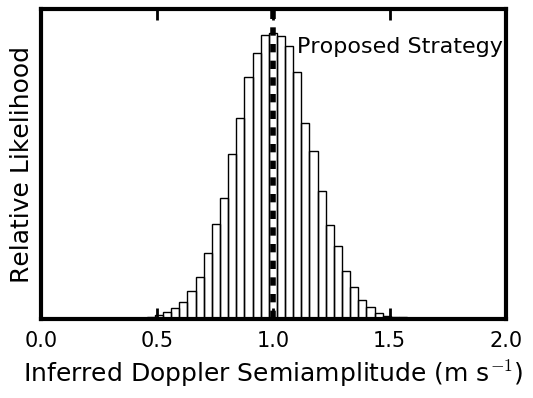

0.9998066888309058 0.9992783201416573
0.49805
0.1666
0.0281
0.00335
0.0001


In [87]:
plt.hist(out_mass, np.arange(0.0, 2.0, 0.035), facecolor='none')
plt.xlabel('Inferred Doppler Semiamplitude (m s$^{-1}$)', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Relative Likelihood', fontsize=18)
plt.yticks([],[])
plt.xlim(0.0, 2.0)
plt.text(1.1, 1550, 'Proposed Strategy', fontsize=16)
plt.savefig('f3.png')
plt.axvline(1.0, linestyle='--', color='k', linewidth=4)
plt.show()

print(np.mean(out_mass), np.median(out_mass))

print(len(out_mass[out_mass > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 1*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 2*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 3*out_sigma > 1.00])/len(out_mass))
print(len(out_mass[out_mass - 1.0 > 1.00])/len(out_mass))



This looks reasonable! We can do careful statistics with this dataset. What about only the planets that are detected in a fixed number of epochs?

0.1283
0.5066250974279034
0.2092751363990647
0.05222135619641465
0.014029618082618862
0.000779423226812159


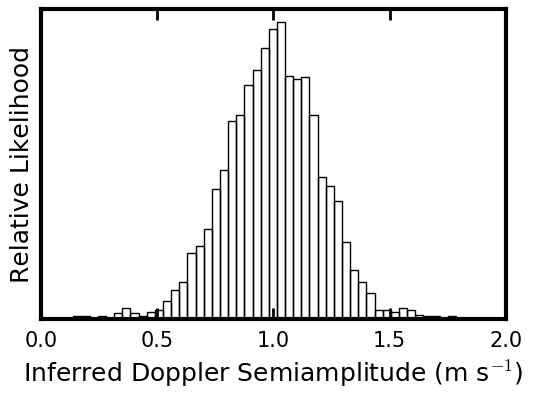

In [89]:
print(len(out_i[out_i < 60])/niter)

out_mass60 = out_mass[out_i < 60]
out_sigma60 = out_sigma[out_i < 60]

print(len(out_mass60[out_mass60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 1*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 2*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 3*out_sigma60 > 1.00])/len(out_mass60))
print(len(out_mass60[out_mass60 - 1.0 > 1.00])/len(out_mass60))

plt.hist(out_mass60, np.arange(0., 2.0, 0.035), facecolor='none')
plt.xlabel('Inferred Doppler Semiamplitude (m s$^{-1}$)', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Relative Likelihood', fontsize=18)
plt.yticks([],[])
plt.savefig('f4.png')
plt.show()


Yes, those look reasonable too!